In [388]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

sc.settings.verbosity=3
#verbosity: errors (0), warnings(1), info(2), hints(3)
sc.logging.print_versions()
#the file that will store analysis results
results_file='Users/caroline/Desktop/Hashing_analysis/write/Hashing_results.h5ad' 

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [389]:
sc.settings.set_figure_params(dpi=80)

In [390]:
#read in our data
adata=anndata.read_h5ad('/Users/caroline/Desktop/Hashed_analysis/Hashed_secondary_output_Hashed_Hashed_demux.h5ad')
adata

AnnData object with n_obs × n_vars = 70351 × 33538 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment'
    var: 'gene_ids', 'robust'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

In [391]:
#filter out doublets, triplets & unknowns
adata=adata[adata.obs['demux_type']=='singlet']
adata

View of AnnData object with n_obs × n_vars = 24917 × 33538 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment'
    var: 'gene_ids', 'robust'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


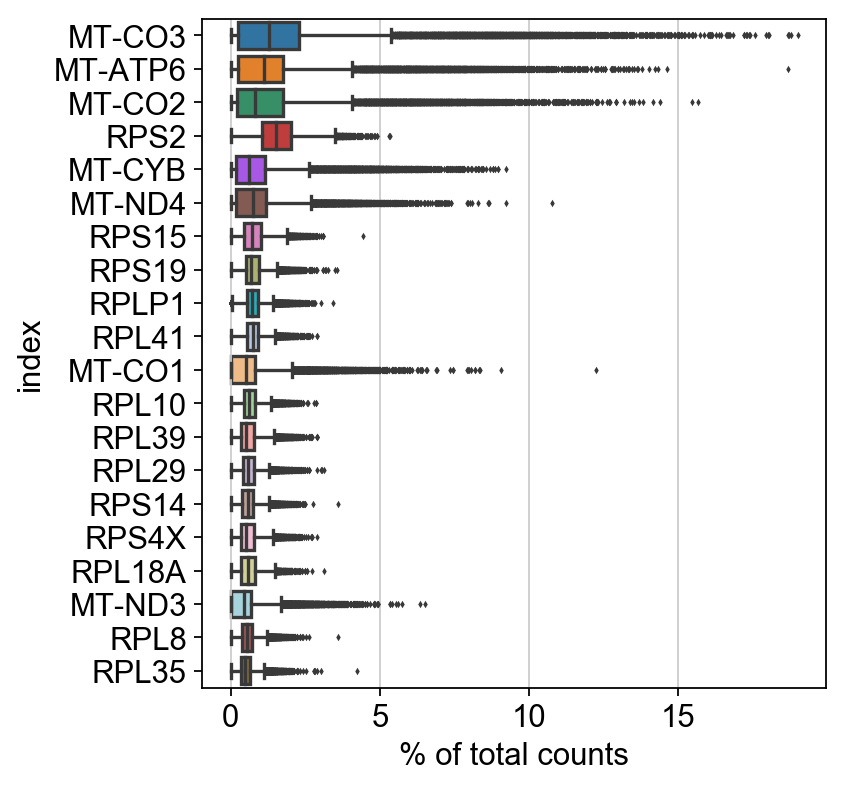

In [392]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [393]:
#filtering out low genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 91 cells that haveless than 200 genes expressed


Trying to set attribute `.obs` of view, making a copy.


filtered out 11892 genes that are detectedin less than 3 cells


In [394]:
#This calculates basic qc metrics, but I'm commenting it out for now
#sc.pp.calculate_qc_metrics(adata)

In [395]:
#calculate mitochondrial genes detected
mito_genes=adata.var_names.str.startswith('MT-')
#for each cell, compute fraction of counts in mito genes vs all genes
#the '.A1' is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito']=np.sum(adata[:, mito_genes].X, axis=1).A1/np.sum(adata.X, axis=1).A1
#add the total counts per cell as observations-annotation to adata
adata.obs['n_counts']=adata.X.sum(axis=1).A1

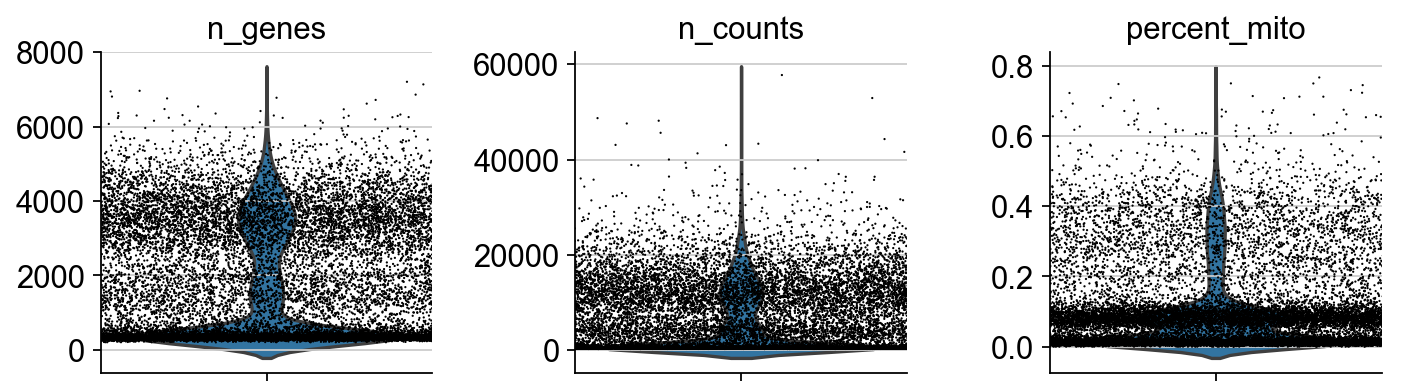

In [396]:
#a violin plot of the computed quality measures
sc.pl.violin(adata, ['n_genes','n_counts','percent_mito'], jitter=0.7, multi_panel=True)

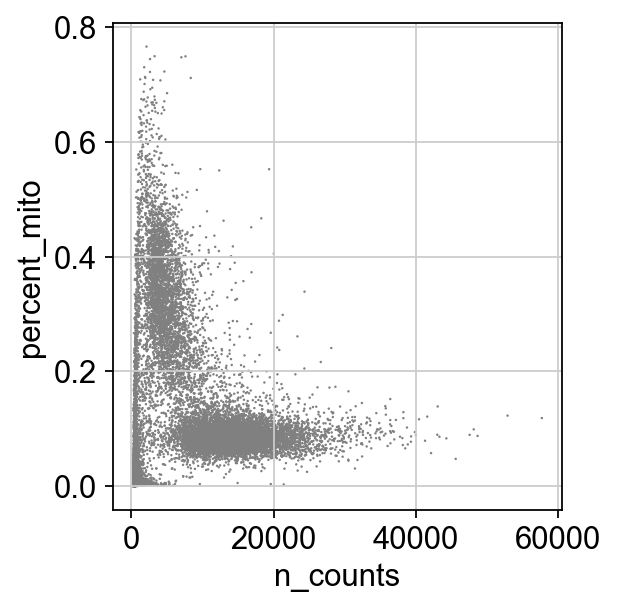

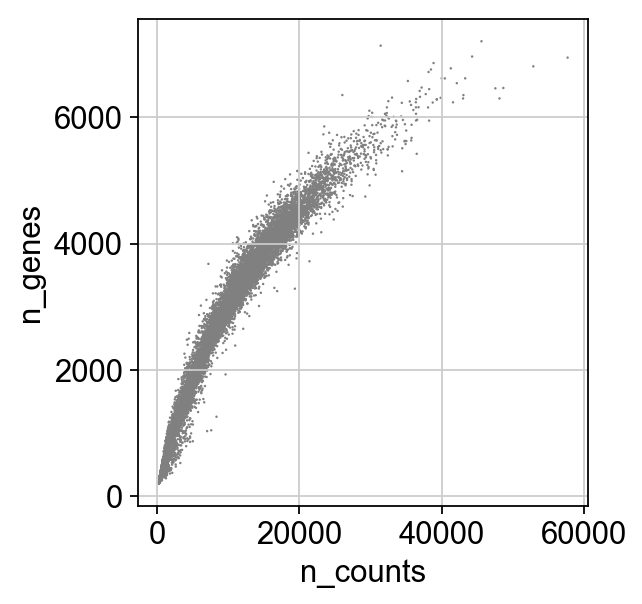

In [397]:
#remove cells that have too many mitochondrial genes expressed or too many total counts
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts',y='n_genes')

In [400]:
#filtering
adata=adata[adata.obs['n_genes']<6000, :]
adata=adata[adata.obs['percent_mito']<0.2, :]
adata=adata[adata.obs['percent_mito']>0.05, :]
adata=adata[adata.obs['n_counts']>1500, :]
adata

View of AnnData object with n_obs × n_vars = 8580 × 21646 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells'
    uns: 'background_probs', 'genome'
    obsm: 'raw_probs'

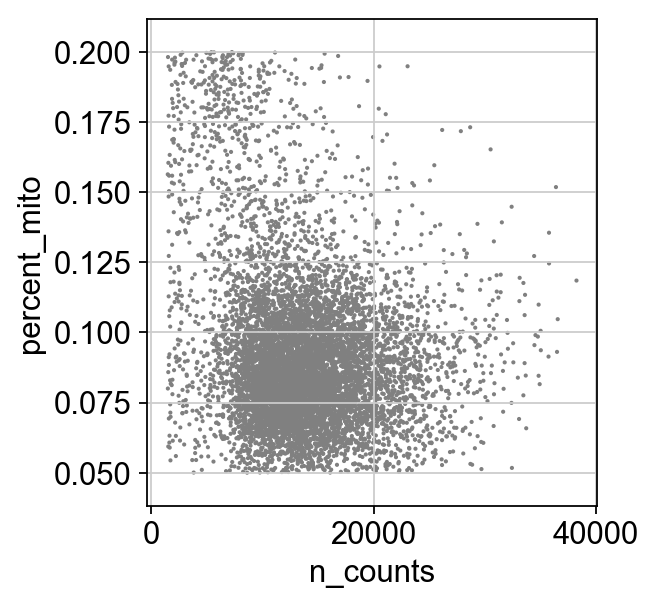

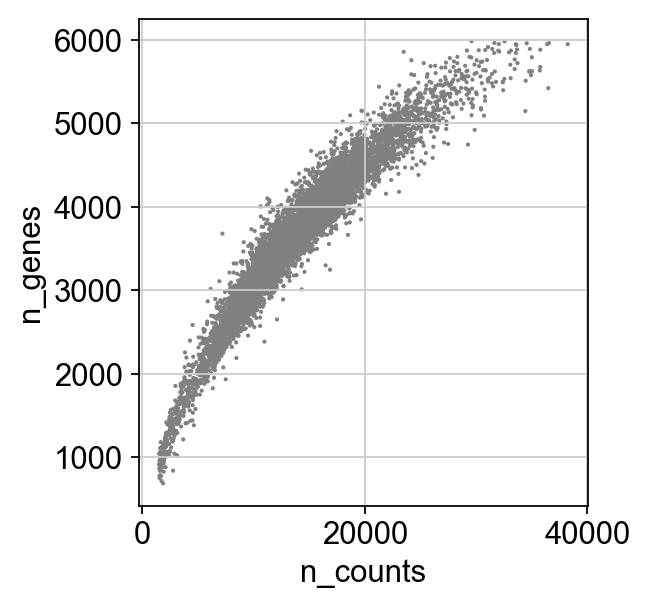

In [401]:
#remove cells that have too many mitochondrial genes expressed or too many total counts
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts',y='n_genes')

In [402]:
#total count normalize (library-size correct) the data matrix 
#to 10,000 reads per cell, so that counts become comparable among cells
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [403]:
#logarithmize the data
sc.pp.log1p(adata)

In [404]:
#set the .raw attribute of adata to the logarithmized raw gene expression 
#for later use in differential testing and visualizations of gene expression.
#This simply freezes the state of the adata object
adata.raw=adata

In [405]:
#Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


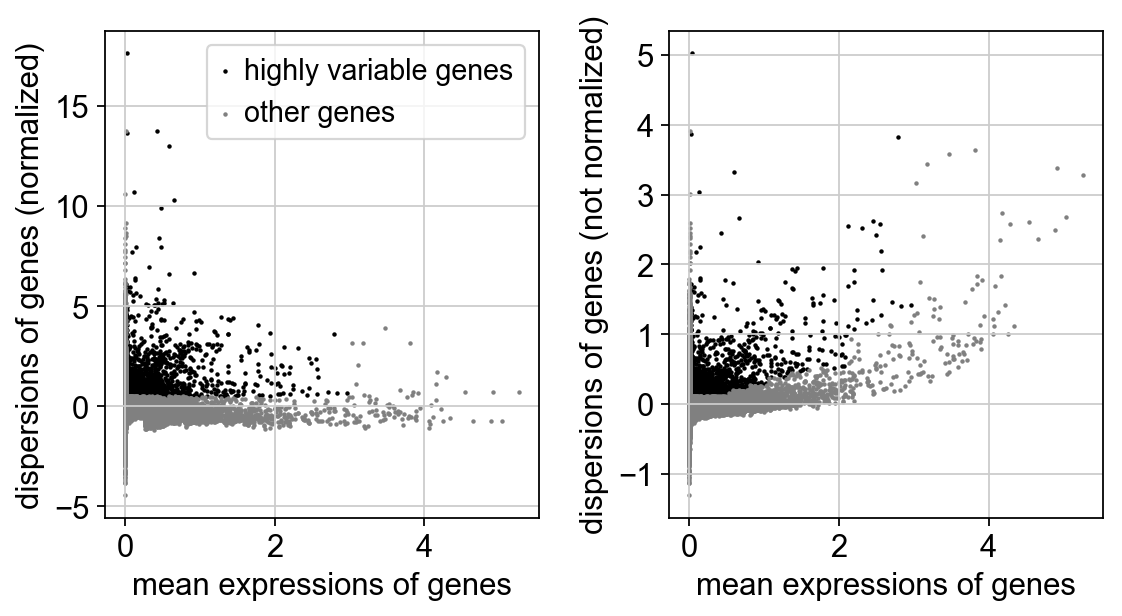

In [406]:
sc.pl.highly_variable_genes(adata)

In [407]:
#filter - not actually needed, can just flag the variable genes instead
adata=adata[:, adata.var['highly_variable']]

In [408]:
#regress out effects of total counts per cell and % mito.
#Scale the data to unit variance
sc.pp.regress_out(adata, ['n_counts','percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:15)


In [409]:
#Scale each gene to unit variance. Clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10)

In [410]:
#Principal component analysis to reduce dimensionality of the data
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)


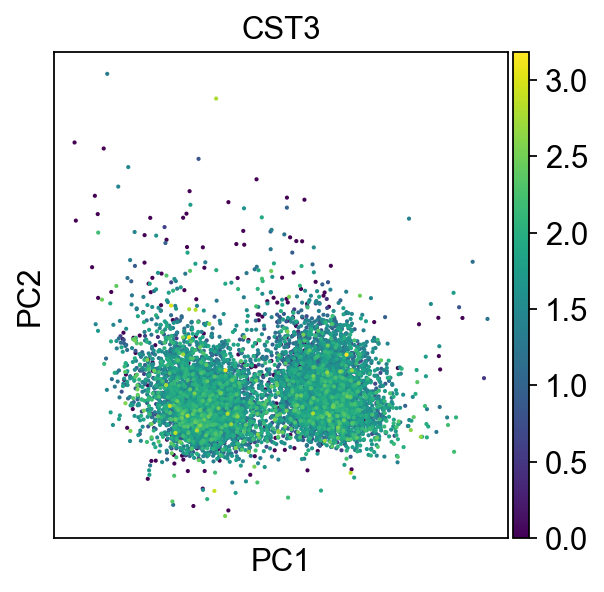

In [411]:
#scatter plot in the PCA coordinates
sc.pl.pca(adata, color='CST3')

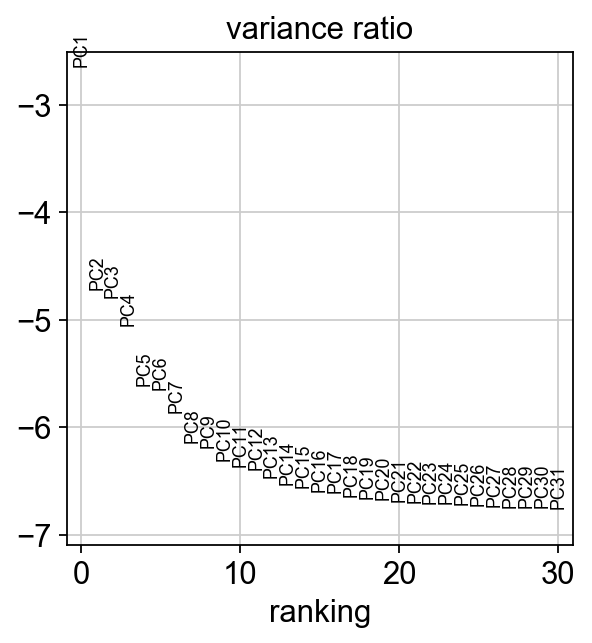

In [412]:
#Let's inspect the contribution of single PCs to the total variance in the data.
#This gives us information on how many PCs we should consider un order to compute
#the neighborhood relations of cells, eg used in the clutering function sc.tl.louvain()
#or tSNE sc.tl.tsne()

sc.pl.pca_variance_ratio(adata, log=True)

In [413]:
#save the result
adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 8580 × 2203 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'background_probs', 'genome', 'pca'
    obsm: 'raw_probs', 'X_pca'
    varm: 'PCs'

In [414]:
#Computing the neighborhood graph using the PCA representation
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/caroline/opt/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [415]:
#Embedding the graph in 2 dimensions using UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


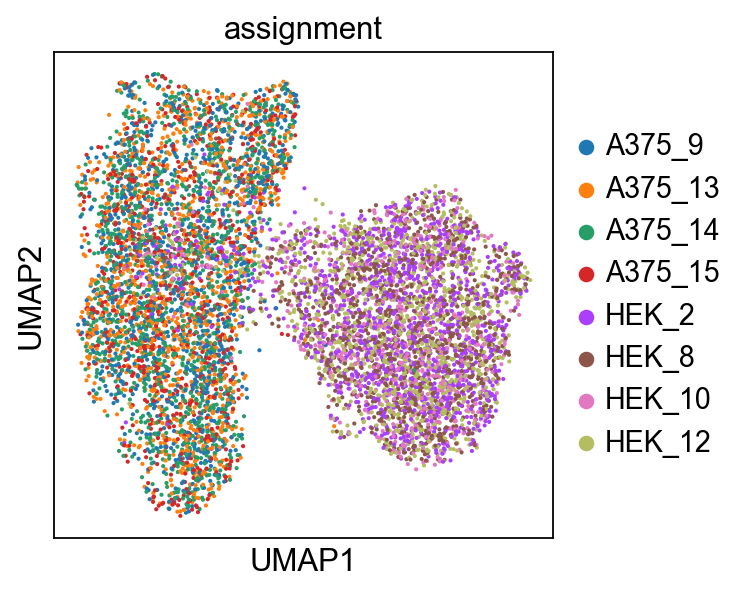

In [416]:
sc.pl.umap(adata, color=['assignment'])

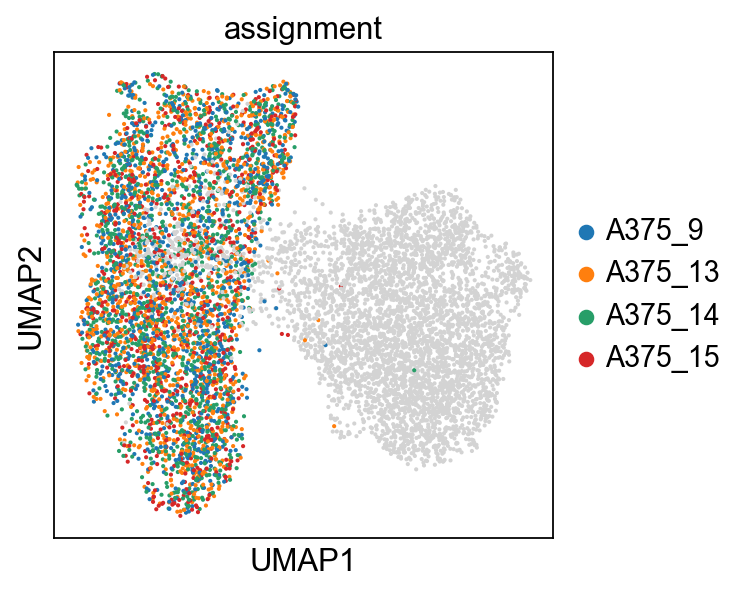

In [417]:
sc.pl.umap(adata, color=['assignment'], groups=['A375_9', 'A375_13', 'A375_14', 'A375_15'])

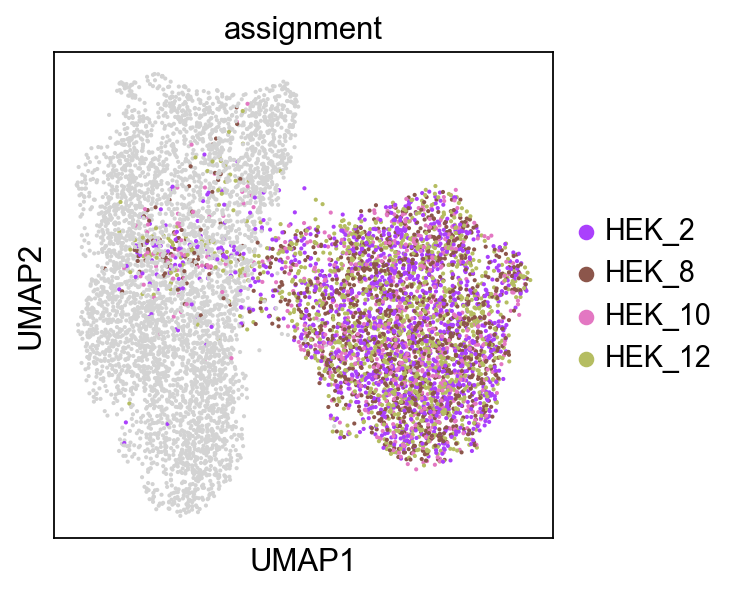

In [418]:
sc.pl.umap(adata, color=['assignment'], groups=['HEK_2', 'HEK_8', 'HEK_10', 'HEK_12'])

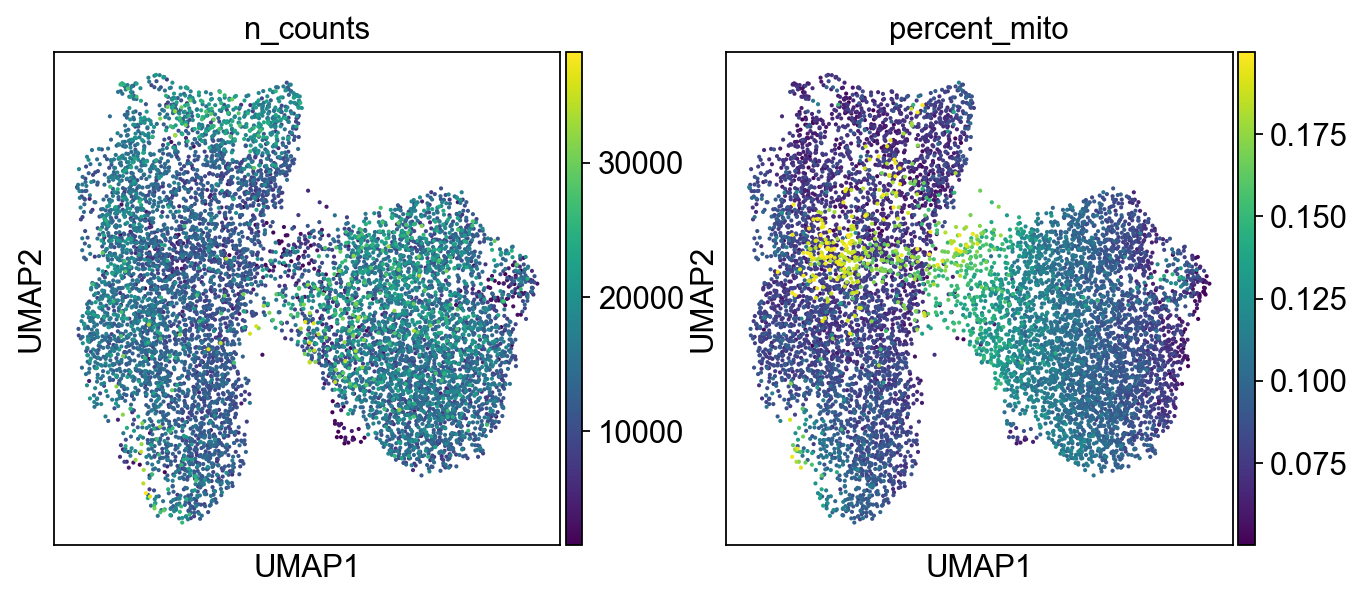

In [419]:
sc.pl.umap(adata, color=['n_counts', 'percent_mito'])

In [420]:
adata

AnnData object with n_obs × n_vars = 8580 × 2203 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito'
    var: 'gene_ids', 'robust', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'background_probs', 'genome', 'pca', 'neighbors', 'assignment_colors'
    obsm: 'raw_probs', 'X_pca', 'X_umap'
    varm: 'PCs'

In [421]:
#You can also plot the scaled and corrected gene expression by explicitly stating 
#that you don't want to use .raw

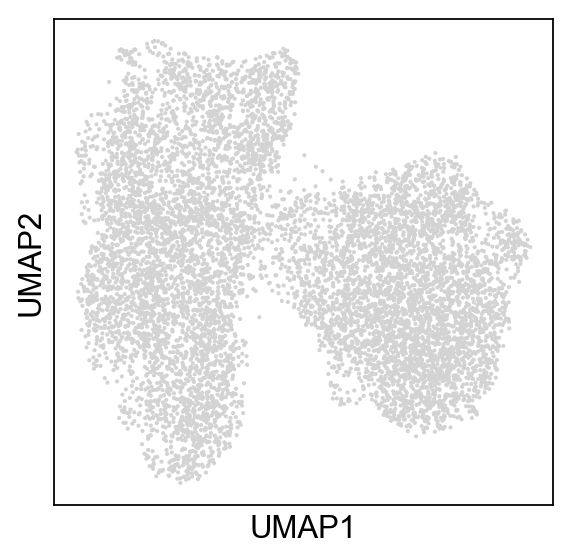

In [422]:
sc.pl.umap(adata, use_raw=False)
#note: none of the genes from above worked in this case....

In [446]:
#Clustering the neighborhood graph - recommended to use the Louvain graph-clutering method
#Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section
sc.tl.louvain(adata, resolution=0.2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 2 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


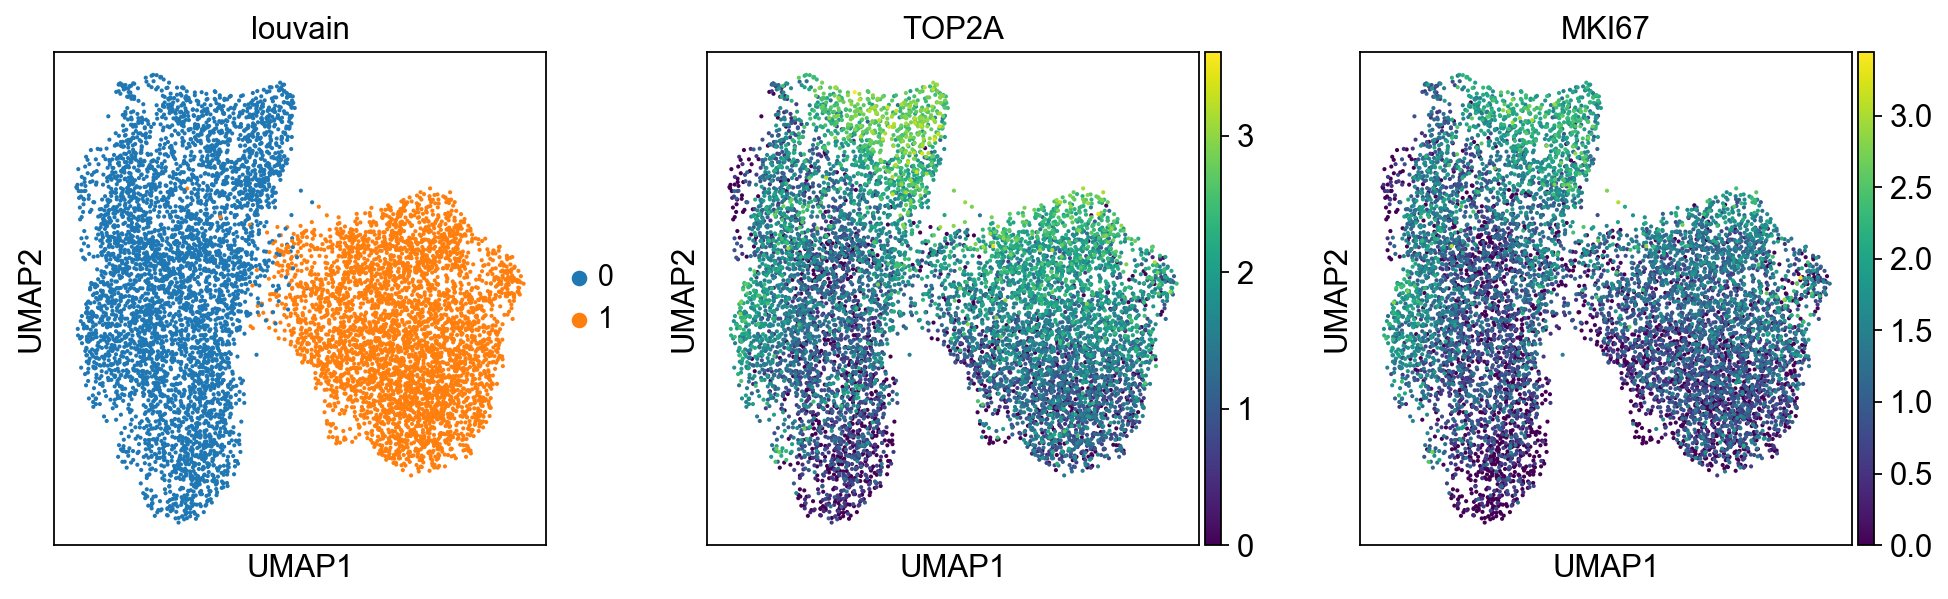

In [451]:
#Plot the clusters
sc.pl.umap(adata, color=['louvain', 'TOP2A', 'MKI67'])

In [452]:
#save the result
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


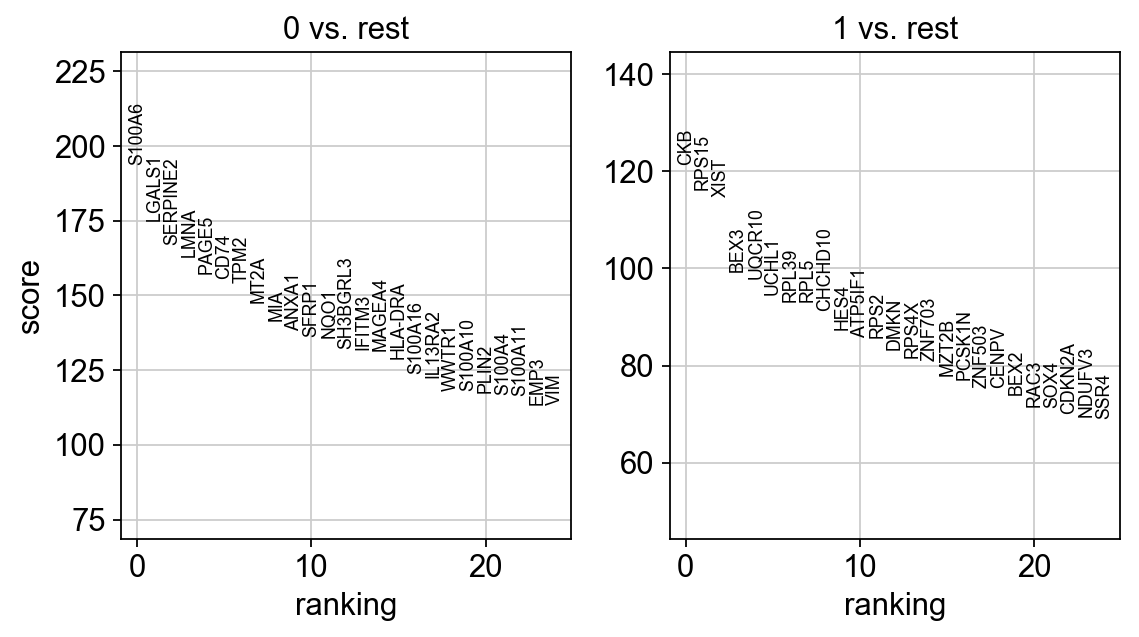

In [453]:
#Finding marker genes
#Using a t-test
sc.tl.rank_genes_groups(adata, 'louvain', methods='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


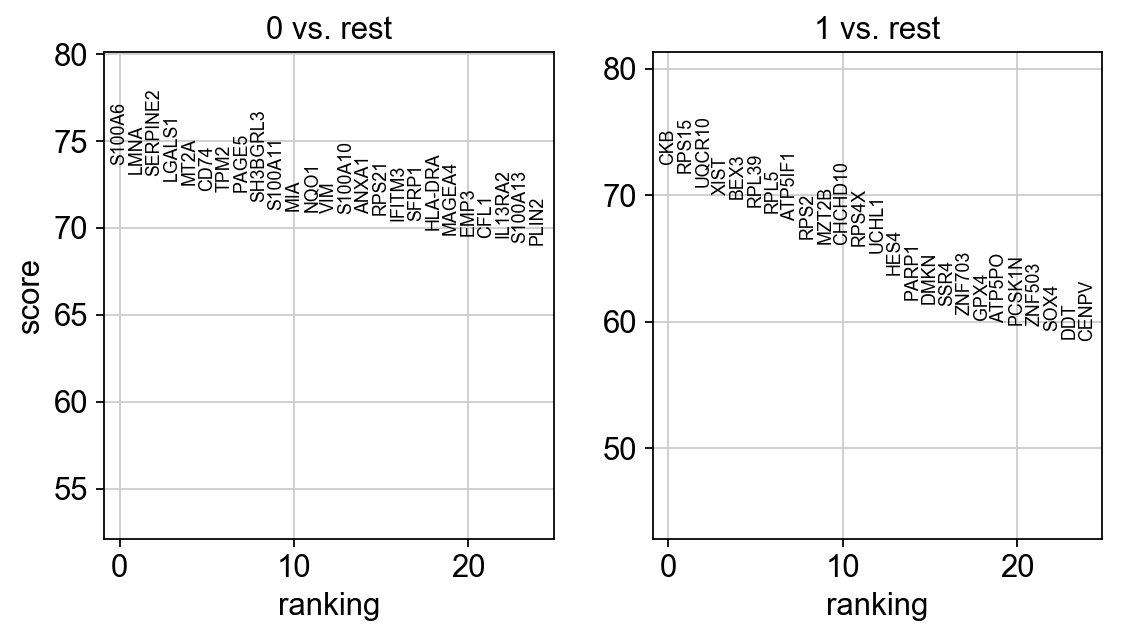

In [454]:
#Ranking genes using a wolcoxon rank-sum test
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [455]:
#save the result
adata.write(results_file)

In [456]:
#as an alternative: rank genes using logistic regression
#sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
#sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [457]:
#let us define a list of marker genes for later reference
#this is what was in the tutorial... need to change for HEK and A375?
#marker_genes=['IL7R', 'CD79A', 'CD8A', 'LYZ', 'CD14', 'LGALS3', 'GNLY', 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3']

In [458]:
#reload the object that was saved with the Wolcoxon Rank-Sum text
#for some reason this fucks up my code in the next block, so I commented it out
#adata=sc.read(results_file)

In [459]:
#show the top 10 ranked genes per cluster in a dataframe
ranked_genes=pd.DataFrame(adata.uns['rank_genes_groups']['names'])
ranked_genes.head(5)

0       1
0    S100A6     CKB
1      LMNA   RPS15
2  SERPINE2  UQCR10
3    LGALS1    XIST
4      MT2A    BEX3

In [460]:
#set the marker genes to the top ranked genes above
marker_genes=['RPL39', 'S100A6', 'ATP6V0E1', 'RPL39', 'CKB', 'RPS27A', 'RPL26', 'XIST', 'SERPINE2', 'TUBA1B', 'RPL39', 'CDCA4', 'BEX3']

In [461]:
#Get a table with the scores and groups
result=adata.uns['rank_genes_groups']
groups=result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group] for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p     1_n  1_p
0    S100A6  0.0     CKB  0.0
1      LMNA  0.0   RPS15  0.0
2  SERPINE2  0.0  UQCR10  0.0
3    LGALS1  0.0    XIST  0.0
4      MT2A  0.0    BEX3  0.0

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


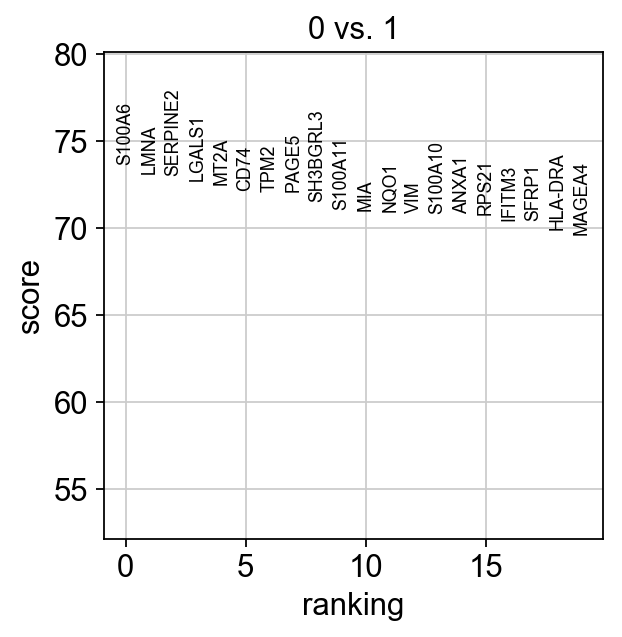

In [462]:
#compare to a single cluster
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

/Users/caroline/opt/anaconda3/lib/python3.7/site-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


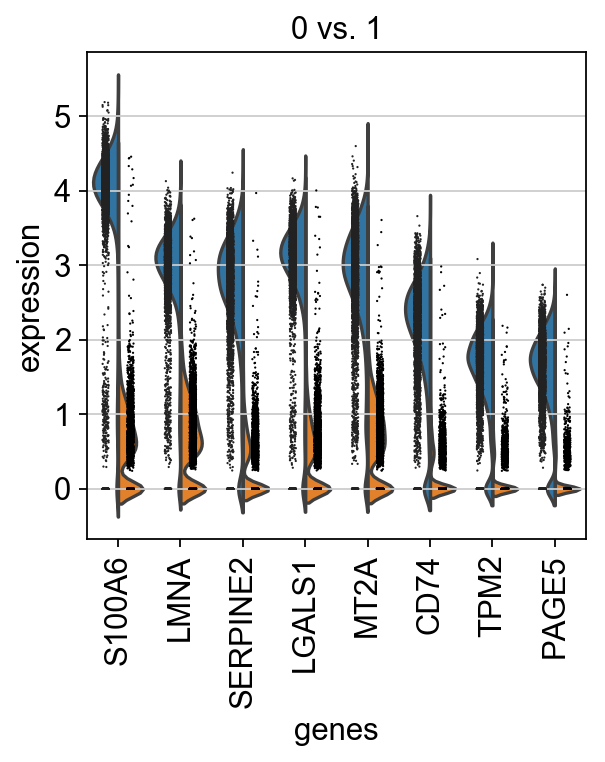

In [463]:
#to get a more detailed view for a certain group:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

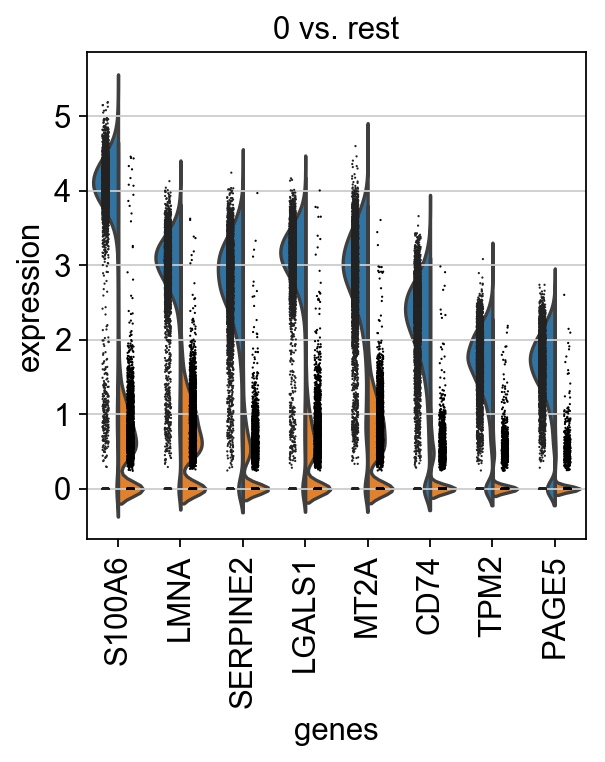

In [464]:
#rteload the object that computed differential expression by comparing to the rest of the groups
adata=sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

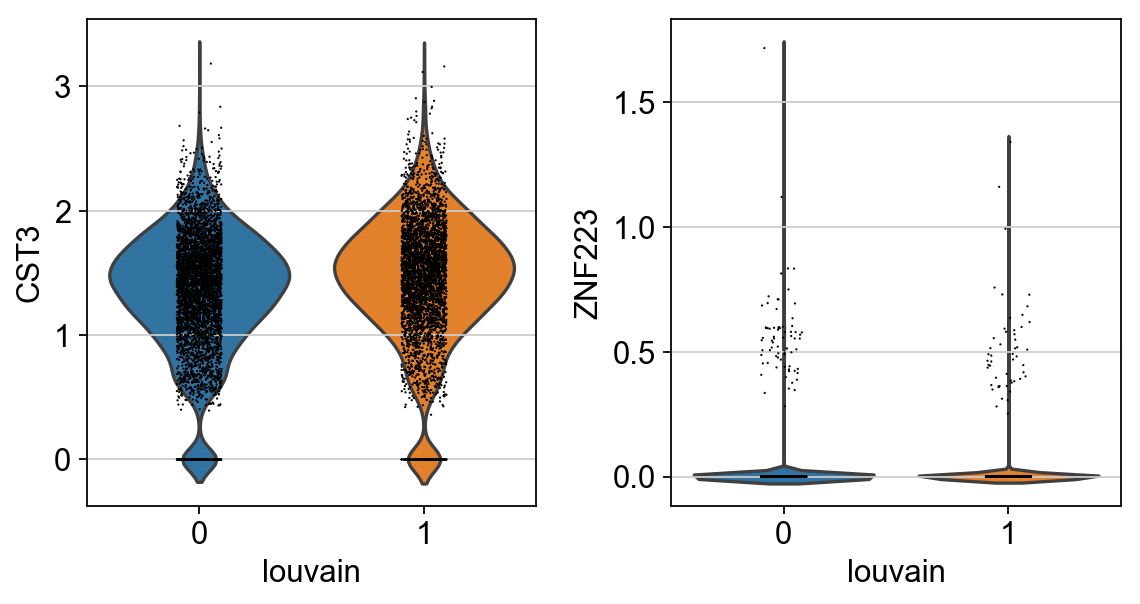

In [465]:
#if you want to compare a certain gene across groups:
sc.pl.violin(adata, ['CST3', 'ZNF223'], groupby='louvain')

In [466]:
#mark the cell types
#new_cluster_names=[]
#adata.rename_categories('louvain', new_cluster_names)

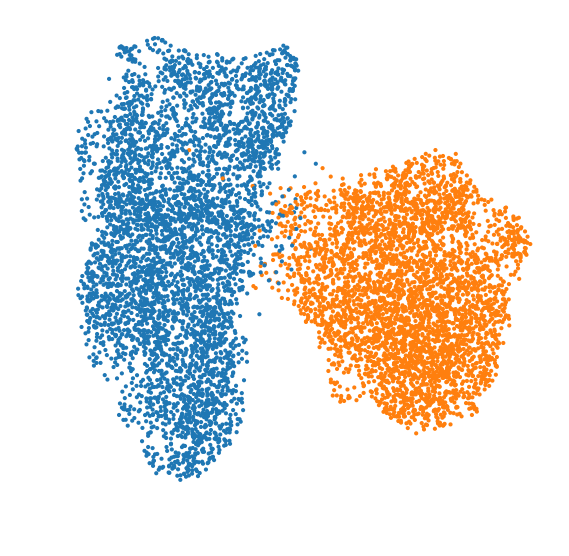

In [467]:
sc.pl.umap(adata, color='louvain', legend_loc='on_data', title='', frameon=False, save='.pdf')

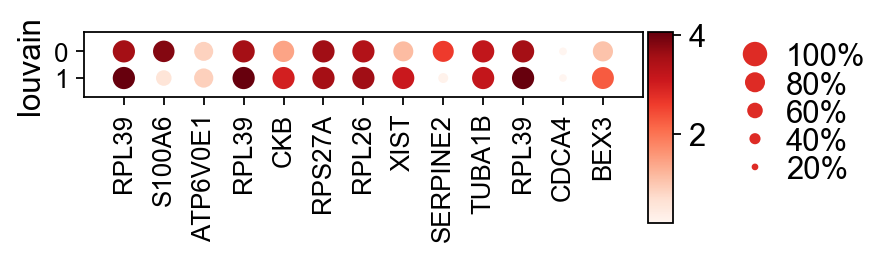

In [468]:
#visualize the marker genes
#my marker genes are the top rated genes for each group
ax=sc.pl.dotplot(adata, marker_genes, groupby='louvain')

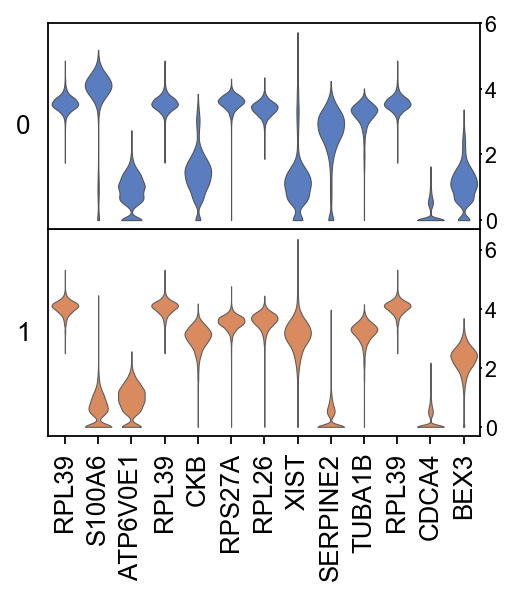

In [469]:
#a compact violin plot
ax=sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

In [470]:
#during the course of this analysis, the AnnData accumulated the following annotations
adata

AnnData object with n_obs × n_vars = 8580 × 2203 
    obs: 'Channel', 'n_genes', 'n_counts', 'demux_type', 'assignment', 'percent_mito', 'louvain'
    var: 'gene_ids', 'robust', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'assignment_colors', 'background_probs', 'genome', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'raw_probs'
    varm: 'PCs'

In [471]:
#compression saves disk space, but slows down writing and subsequent reading
#adata.write(results_file, compression='gzip')

#if you want to share this file with people who just want to use it for visualization, 
#a simple way to reduce file size is by removing the dense scaled and corrected data matrix
#The file still contains the raw data used in the visualizations
#adata.X=None
#adata.write('./write/Hashing_withoutX.h5ad', compression='gzip')

In [472]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )